Import the required libraries

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Core hyperparams
LATENT_DIM = 40
HIDDEN_DIM = 400
BATCH_SIZE = 128
LR = 3e-4
EPOCHS = 50
NUM_PSEUDO_INPUTS = 500


Dataset Loading

In [38]:
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)

test_dataset = datasets.MNIST(
    root="./data", train=False, transform=transform, download=True
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


Encoder

In [39]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, HIDDEN_DIM)
        self.fc_mu = nn.Linear(HIDDEN_DIM, LATENT_DIM)
        self.fc_logvar = nn.Linear(HIDDEN_DIM, LATENT_DIM)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar


Decoder

In [40]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(LATENT_DIM, HIDDEN_DIM)
        self.fc_out = nn.Linear(HIDDEN_DIM, 28 * 28)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        x_logits = self.fc_out(h)
        return x_logits.view(-1, 1, 28, 28)


Reparameterization trick

In [41]:
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

def log_normal_diag(z, mu, logvar):
    log2pi = math.log(2 * math.pi)
    return -0.5 * (
        log2pi
        + logvar
        + (z - mu) ** 2 / torch.exp(logvar)
    ).sum(dim=-1)


Pseudo Inputs

In [42]:
class PseudoInputs(nn.Module):
    def __init__(self, K):
        super().__init__()
        self.K = K
        self.pseudo_inputs = nn.Parameter(
            torch.randn(K, 1, 28, 28)
        )

    def forward(self):
        return torch.sigmoid(self.pseudo_inputs)


VampVAE Class

In [43]:
class VampVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.pseudo_inputs = PseudoInputs(NUM_PSEUDO_INPUTS)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = reparameterize(mu, logvar)
        x_logits = self.decoder(z)
        return x_logits, z, mu, logvar

def log_vampprior(z, model):
    pseudo_x = model.pseudo_inputs()
    K = pseudo_x.size(0)

    mu_p, logvar_p = model.encoder(pseudo_x)
    mu_p = mu_p.unsqueeze(0)
    logvar_p = logvar_p.unsqueeze(0)

    z = z.unsqueeze(1)

    log_qz = log_normal_diag(z, mu_p, logvar_p)
    log_qz = torch.logsumexp(log_qz, dim=1) - torch.log(torch.tensor(K, device=z.device))

    return log_qz

def vamp_loss(model, x):
    x_logits, z, mu, logvar = model(x)

    recon_loss = F.binary_cross_entropy_with_logits(
        x_logits, x, reduction="sum"
    )

    log_qzx = log_normal_diag(z, mu, logvar)
    log_pz = log_vampprior(z, model)

    kl = (log_qzx - log_pz).sum()

    return recon_loss + kl, recon_loss, kl



Model Training

In [45]:
vamp_model = VampVAE().to(device)
optimizer = torch.optim.Adam(vamp_model.parameters(), lr=LR)

for epoch in range(EPOCHS):
    vamp_model.train()
    total_loss, total_recon, total_kl = 0, 0, 0

    for x, _ in train_loader:
        x = x.to(device)

        optimizer.zero_grad()
        loss, recon, kl = vamp_loss(vamp_model, x)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon += recon.item()
        total_kl += kl.item()

        N = len(train_dataset)

    print(
        f"Epoch {epoch+1:02d} | "
        f"Loss {total_loss/N:.2f} | "
        f"Recon {total_recon/N:.2f} | "
        f"KL {total_kl/N:.2f}"
    )


Epoch 01 | Loss 197.05 | Recon 189.81 | KL 7.25
Epoch 02 | Loss 139.75 | Recon 126.01 | KL 13.74
Epoch 03 | Loss 126.88 | Recon 110.38 | KL 16.49
Epoch 04 | Loss 120.47 | Recon 102.44 | KL 18.03
Epoch 05 | Loss 116.37 | Recon 97.35 | KL 19.02
Epoch 06 | Loss 113.57 | Recon 93.93 | KL 19.64
Epoch 07 | Loss 111.45 | Recon 91.38 | KL 20.06
Epoch 08 | Loss 109.81 | Recon 89.39 | KL 20.42
Epoch 09 | Loss 108.42 | Recon 87.77 | KL 20.65
Epoch 10 | Loss 107.36 | Recon 86.51 | KL 20.85
Epoch 11 | Loss 106.40 | Recon 85.42 | KL 20.98
Epoch 12 | Loss 105.56 | Recon 84.46 | KL 21.10
Epoch 13 | Loss 104.91 | Recon 83.71 | KL 21.19
Epoch 14 | Loss 104.31 | Recon 83.01 | KL 21.30
Epoch 15 | Loss 103.76 | Recon 82.40 | KL 21.36
Epoch 16 | Loss 103.30 | Recon 81.87 | KL 21.43
Epoch 17 | Loss 102.88 | Recon 81.37 | KL 21.50
Epoch 18 | Loss 102.51 | Recon 80.95 | KL 21.56
Epoch 19 | Loss 102.15 | Recon 80.56 | KL 21.59
Epoch 20 | Loss 101.84 | Recon 80.19 | KL 21.65
Epoch 21 | Loss 101.51 | Recon 79.83 

In [12]:
# z = torch.randn(8, 40)
# mu = torch.zeros_like(z)
# logvar = torch.zeros_like(z)

# print(log_normal_diag(z, mu, logvar))


tensor([-52.3937, -55.9277, -59.5364, -51.0511, -59.4843, -55.4258, -49.5235,
        -54.7058])


In [46]:
vamp_model.eval()
with torch.no_grad():
    pseudo = vamp_model.pseudo_inputs()
    print("Pseudo-input stats:", pseudo.mean().item(), pseudo.std().item())


Pseudo-input stats: 0.49813464283943176 0.21343807876110077


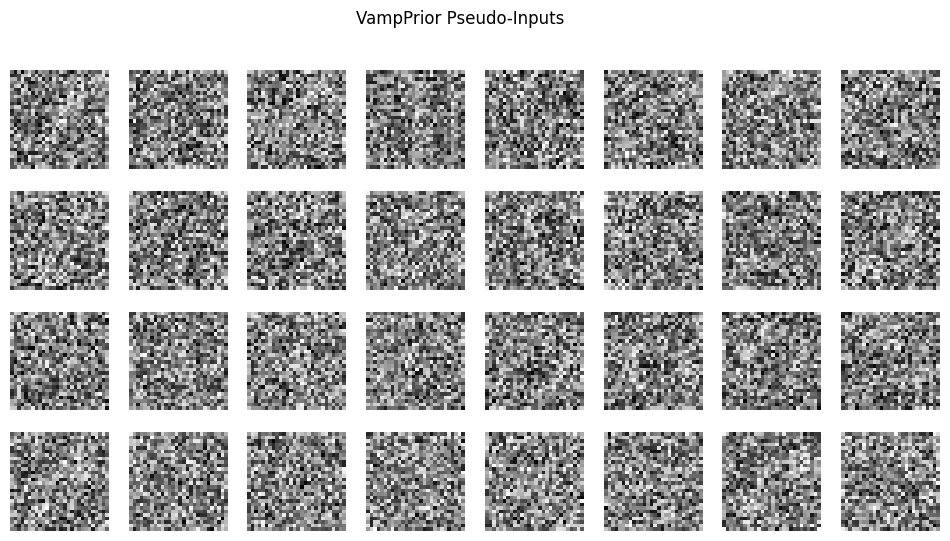

In [47]:
import matplotlib.pyplot as plt

vamp_model.eval()
pseudo = vamp_model.pseudo_inputs().detach().cpu()

fig, axes = plt.subplots(4, 8, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(pseudo[i, 0], cmap="gray")
    ax.axis("off")

plt.suptitle("VampPrior Pseudo-Inputs")
plt.show()


Standard VAE Training

In [48]:
class StandardVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()  # same as VampVAE encoder
        self.decoder = Decoder()  # same as VampVAE decoder

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = reparameterize(mu, logvar)
        x_logits = self.decoder(z)
        return x_logits, z, mu, logvar


In [49]:
def standard_vae_loss(x_logits, x, z, mu, logvar):
    # Reconstruction loss
    recon = F.binary_cross_entropy_with_logits(
        x_logits, x, reduction="sum"
    )
    # KL divergence (analytical)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kl, recon, kl


In [50]:
# Instantiate model
standard_model = StandardVAE().to(device)
optimizer_std = torch.optim.Adam(standard_model.parameters(), lr=LR)

for epoch in range(EPOCHS):
    standard_model.train()
    total_loss, total_recon, total_kl = 0, 0, 0

    for x, _ in train_loader:
        x = x.to(device)
        optimizer_std.zero_grad()

        x_logits, z, mu, logvar = standard_model(x)
        loss, recon, kl = standard_vae_loss(x_logits, x, z, mu, logvar)
        loss.backward()
        optimizer_std.step()

        total_loss += loss.item()
        total_recon += recon.item()
        total_kl += kl.item()

    N = len(train_dataset)
    print(
        f"Epoch {epoch+1:02d} | "
        f"Loss {total_loss/N:.2f} | "
        f"Recon {total_recon/N:.2f} | "
        f"KL {total_kl/N:.2f}"
    )


Epoch 01 | Loss 207.55 | Recon 193.18 | KL 14.37
Epoch 02 | Loss 149.30 | Recon 129.05 | KL 20.26
Epoch 03 | Loss 135.34 | Recon 112.29 | KL 23.05
Epoch 04 | Loss 127.96 | Recon 103.54 | KL 24.42
Epoch 05 | Loss 123.10 | Recon 97.86 | KL 25.24
Epoch 06 | Loss 119.41 | Recon 93.68 | KL 25.73
Epoch 07 | Loss 116.75 | Recon 90.70 | KL 26.05
Epoch 08 | Loss 114.74 | Recon 88.42 | KL 26.32
Epoch 09 | Loss 113.31 | Recon 86.78 | KL 26.52
Epoch 10 | Loss 112.13 | Recon 85.44 | KL 26.69
Epoch 11 | Loss 111.22 | Recon 84.39 | KL 26.83
Epoch 12 | Loss 110.39 | Recon 83.51 | KL 26.88
Epoch 13 | Loss 109.72 | Recon 82.79 | KL 26.92
Epoch 14 | Loss 109.17 | Recon 82.16 | KL 27.01
Epoch 15 | Loss 108.64 | Recon 81.66 | KL 26.98
Epoch 16 | Loss 108.23 | Recon 81.18 | KL 27.05
Epoch 17 | Loss 107.85 | Recon 80.78 | KL 27.07
Epoch 18 | Loss 107.47 | Recon 80.43 | KL 27.04
Epoch 19 | Loss 107.19 | Recon 80.09 | KL 27.10
Epoch 20 | Loss 106.89 | Recon 79.81 | KL 27.07
Epoch 21 | Loss 106.62 | Recon 79.55

In [51]:
torch.save(standard_model.state_dict(), "standard_vae.pth")
print("Standard VAE saved.")

torch.save(vamp_model.state_dict(), "VampPrior_vae.pth")
print("VampPrior VAE saved.")


Standard VAE saved.
VampPrior VAE saved.


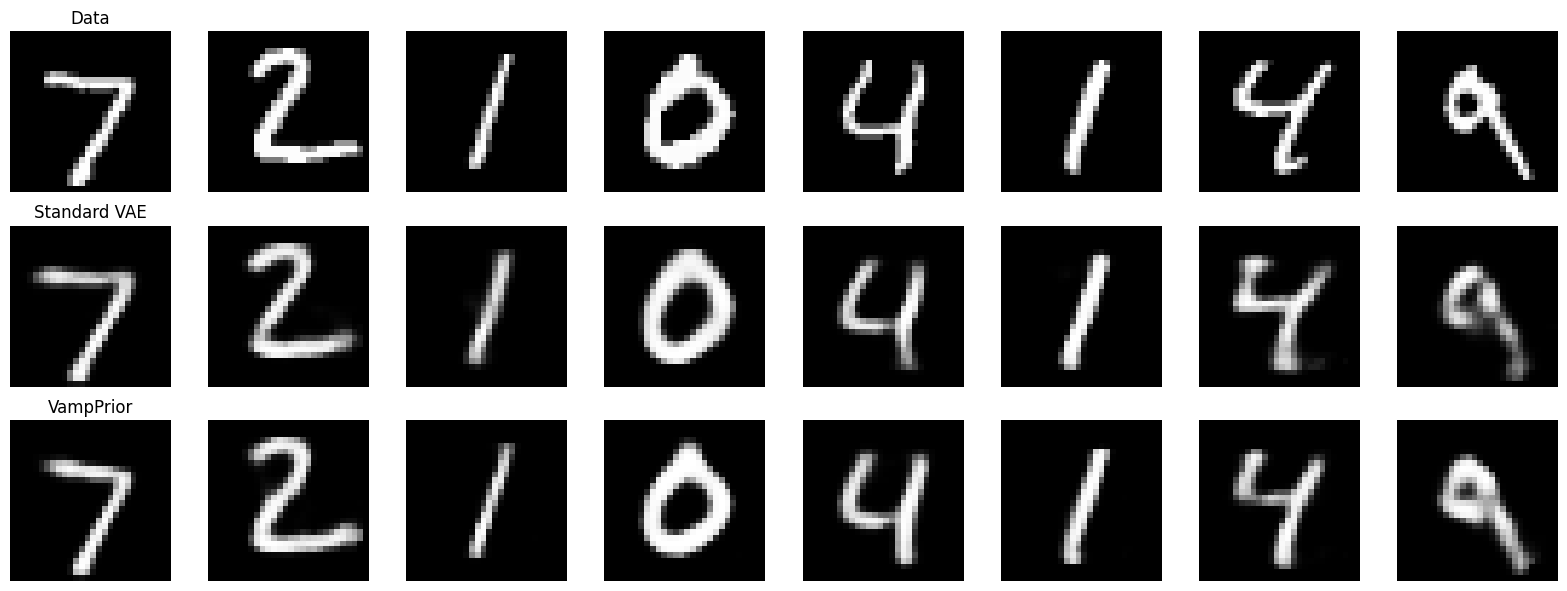

In [24]:
import matplotlib.pyplot as plt

# Make sure both models are in evaluation mode
standard_model.eval()
vamp_model.eval()

# Grab one batch of test data
x, _ = next(iter(test_loader))
x = x.to(device)

with torch.no_grad():
    # VampPrior reconstruction
    x_logits_vamp, _, _, _ = vamp_model(x)
    x_recon_vamp = torch.sigmoid(x_logits_vamp).cpu()

    # Standard VAE reconstruction
    x_logits_std, _, _, _ = standard_model(x)
    x_recon_std = torch.sigmoid(x_logits_std).cpu()

# Move original batch to CPU
x = x.cpu()

n = 8  # number of examples to show
fig, axes = plt.subplots(3, n, figsize=(2*n, 6))

for i in range(n):
    # Original data
    axes[0, i].imshow(x[i, 0], cmap="gray")
    axes[0, i].axis("off")
    if i == 0: axes[0, i].set_title("Data")

    # Standard VAE reconstruction
    axes[1, i].imshow(x_recon_std[i, 0], cmap="gray")
    axes[1, i].axis("off")
    if i == 0: axes[1, i].set_title("Standard VAE")

    # VampPrior reconstruction
    axes[2, i].imshow(x_recon_vamp[i, 0], cmap="gray")
    axes[2, i].axis("off")
    if i == 0: axes[2, i].set_title("VampPrior")

plt.tight_layout()
plt.show()


Hierarchical VAE With VampPrior

In [52]:
class HVampEncoder(nn.Module):
    def __init__(self, latent_dim1=40, latent_dim2=20, hidden_dim=400):
        super().__init__()
        self.fc1 = nn.Linear(28*28, hidden_dim)
        # z1
        self.fc_mu1 = nn.Linear(hidden_dim, latent_dim1)
        self.fc_logvar1 = nn.Linear(hidden_dim, latent_dim1)
        # z2 (conditioned on z1)
        self.fc_mu2 = nn.Linear(latent_dim1, latent_dim2)
        self.fc_logvar2 = nn.Linear(latent_dim1, latent_dim2)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        h = F.relu(self.fc1(x))
        mu1 = self.fc_mu1(h)
        logvar1 = self.fc_logvar1(h)
        # reparameterize z1 for hierarchical z2
        z1 = reparameterize(mu1, logvar1)
        mu2 = self.fc_mu2(z1)
        logvar2 = self.fc_logvar2(z1)
        return mu1, logvar1, mu2, logvar2


In [53]:
class HVampDecoder(nn.Module):
    def __init__(self, latent_dim1=40, latent_dim2=20, hidden_dim=400):
        super().__init__()
        self.fc = nn.Linear(latent_dim1 + latent_dim2, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, 28*28)

    def forward(self, z1, z2):
        h = F.relu(self.fc(torch.cat([z1, z2], dim=1)))
        x_logits = self.fc_out(h)
        return x_logits.view(-1, 1, 28, 28)


In [54]:
class HVampPseudoInputs(nn.Module):
    def __init__(self, K=500):
        super().__init__()
        self.pseudo_inputs = nn.Parameter(torch.randn(K, 1, 28, 28))

    def forward(self):
        return torch.sigmoid(self.pseudo_inputs)


In [55]:
class HVampVAE(nn.Module):
    def __init__(self, latent_dim1=40, latent_dim2=20, hidden_dim=400, K=500):
        super().__init__()
        self.encoder = HVampEncoder(latent_dim1, latent_dim2, hidden_dim)
        self.decoder = HVampDecoder(latent_dim1, latent_dim2, hidden_dim)
        self.pseudo_inputs = HVampPseudoInputs(K)

    def forward(self, x):
        mu1, logvar1, mu2, logvar2 = self.encoder(x)
        z1 = reparameterize(mu1, logvar1)
        z2 = reparameterize(mu2, logvar2)
        x_logits = self.decoder(z1, z2)
        return x_logits, z1, mu1, logvar1, z2, mu2, logvar2


In [56]:
def log_hvampprior(z2, model):
    pseudo_x = model.pseudo_inputs()
    K = pseudo_x.size(0)
    # encode pseudo-inputs through encoder
    _, _, mu2_p, logvar2_p = model.encoder(pseudo_x)
    mu2_p = mu2_p.unsqueeze(0)  # batch dim
    logvar2_p = logvar2_p.unsqueeze(0)
    z2 = z2.unsqueeze(1)
    log_qz = log_normal_diag(z2, mu2_p, logvar2_p)
    # mixture over K
    log_qz = torch.logsumexp(log_qz, dim=1) - torch.log(torch.tensor(K, device=z2.device))
    return log_qz


In [57]:
def hvamp_loss(model, x):
    x_logits, z1, mu1, logvar1, z2, mu2, logvar2 = model(x)
    # reconstruction
    recon_loss = F.binary_cross_entropy_with_logits(x_logits, x, reduction="sum")
    # KL for z1
    log_qz1 = log_normal_diag(z1, mu1, logvar1)
    log_pz1 = log_normal_diag(z1, torch.zeros_like(mu1), torch.zeros_like(logvar1))  # standard normal
    kl1 = (log_qz1 - log_pz1).sum()
    # KL for z2 (VampPrior)
    log_qz2 = log_normal_diag(z2, mu2, logvar2)
    log_pz2 = log_hvampprior(z2, model)
    kl2 = (log_qz2 - log_pz2).sum()
    loss = recon_loss + kl1 + kl2
    return loss, recon_loss, kl1, kl2


In [66]:
# Instantiate model
HVamp_model = HVampVAE().to(device)
optimizer_std = torch.optim.Adam(HVamp_model.parameters(), lr=LR)

for epoch in range(EPOCHS):
    HVamp_model.train()
    total_loss, total_recon, total_kl1, total_kl2 = 0, 0, 0,0

    for x, _ in train_loader:
        x = x.to(device)
        optimizer_std.zero_grad()

        loss, recon, kl1, kl2 = hvamp_loss(HVamp_model, x)
        loss.backward()
        optimizer_std.step()

        total_loss += loss.item()
        total_recon += recon.item()
        total_kl1 += kl1.item()
        total_kl2 += kl2.item()

    N = len(train_dataset)
    print(
        f"Epoch {epoch+1:02d} | "
        f"Loss {total_loss/N:.2f} | "
        f"Recon {total_recon/N:.2f} | "
        f"KL {total_kl1/N:.2f} | "
        f"KL {total_kl2/N:.2f}"
    )


Epoch 01 | Loss 212.88 | Recon 198.45 | KL 11.06 | KL 3.37
Epoch 02 | Loss 157.11 | Recon 137.22 | KL 17.09 | KL 2.80
Epoch 03 | Loss 141.78 | Recon 119.39 | KL 20.69 | KL 1.69
Epoch 04 | Loss 132.55 | Recon 108.91 | KL 22.74 | KL 0.90
Epoch 05 | Loss 126.45 | Recon 102.18 | KL 23.81 | KL 0.46
Epoch 06 | Loss 122.15 | Recon 97.47 | KL 24.45 | KL 0.23
Epoch 07 | Loss 118.98 | Recon 93.98 | KL 24.89 | KL 0.11
Epoch 08 | Loss 116.56 | Recon 91.26 | KL 25.25 | KL 0.05
Epoch 09 | Loss 114.71 | Recon 89.15 | KL 25.53 | KL 0.03
Epoch 10 | Loss 113.21 | Recon 87.47 | KL 25.72 | KL 0.02
Epoch 11 | Loss 111.99 | Recon 86.12 | KL 25.86 | KL 0.02
Epoch 12 | Loss 110.97 | Recon 84.97 | KL 25.99 | KL 0.02
Epoch 13 | Loss 110.10 | Recon 84.03 | KL 26.06 | KL 0.01
Epoch 14 | Loss 109.39 | Recon 83.23 | KL 26.15 | KL 0.01
Epoch 15 | Loss 108.78 | Recon 82.56 | KL 26.21 | KL 0.01
Epoch 16 | Loss 108.22 | Recon 81.95 | KL 26.26 | KL 0.01
Epoch 17 | Loss 107.82 | Recon 81.48 | KL 26.33 | KL 0.01
Epoch 18 

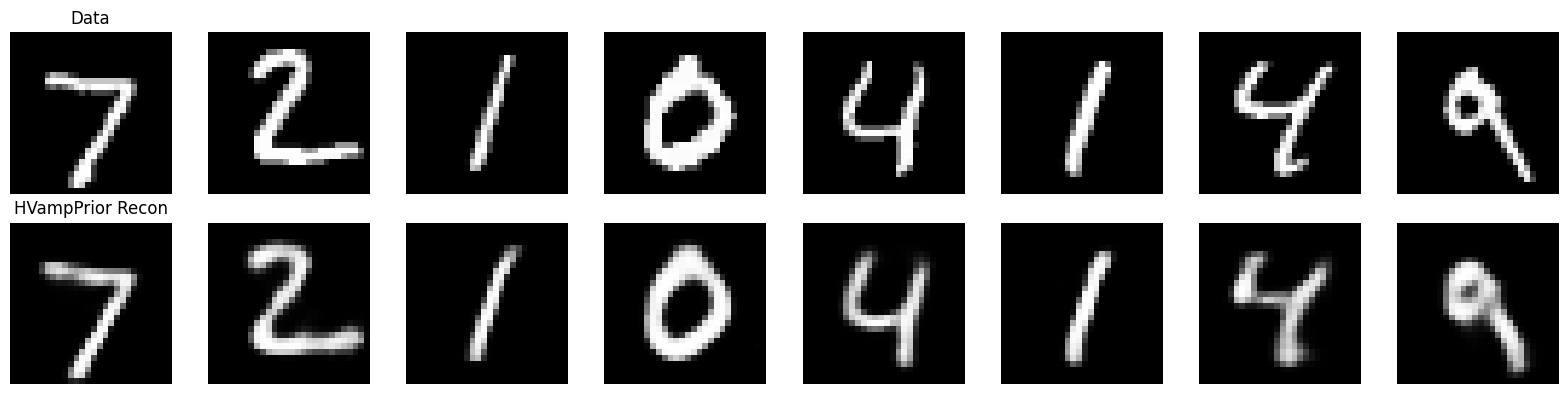

In [63]:
import matplotlib.pyplot as plt

HVamp_model.eval()  # HVampVAE in eval mode

# grab one batch from test_loader
x, _ = next(iter(test_loader))
x = x.to(device)

with torch.no_grad():
    x_logits, z1, mu1, logvar1, z2, mu2, logvar2 = HVamp_model(x)
    x_recon = torch.sigmoid(x_logits).cpu()  # reconstruction

# move input to CPU
x = x.cpu()

n = 8  # number of examples to display
fig, axes = plt.subplots(2, n, figsize=(2*n, 4))

for i in range(n):
    # original data
    axes[0, i].imshow(x[i, 0], cmap="gray")
    axes[0, i].axis("off")
    if i == 0:
        axes[0, i].set_title("Data")

    # HVampPrior reconstruction
    axes[1, i].imshow(x_recon[i, 0], cmap="gray")
    axes[1, i].axis("off")
    if i == 0:
        axes[1, i].set_title("HVampPrior Recon")

plt.tight_layout()
plt.show()

In [67]:
torch.save(standard_model.state_dict(), "standard_vae.pth")
print("Standard VAE saved.")

torch.save(vamp_model.state_dict(), "VampPrior_vae.pth")
print("VampPrior VAE saved.")

torch.save(HVamp_model.state_dict(), "H_VampPrior_vae.pth")
print("H_VampPrior VAE saved.")


Standard VAE saved.
VampPrior VAE saved.
H_VampPrior VAE saved.


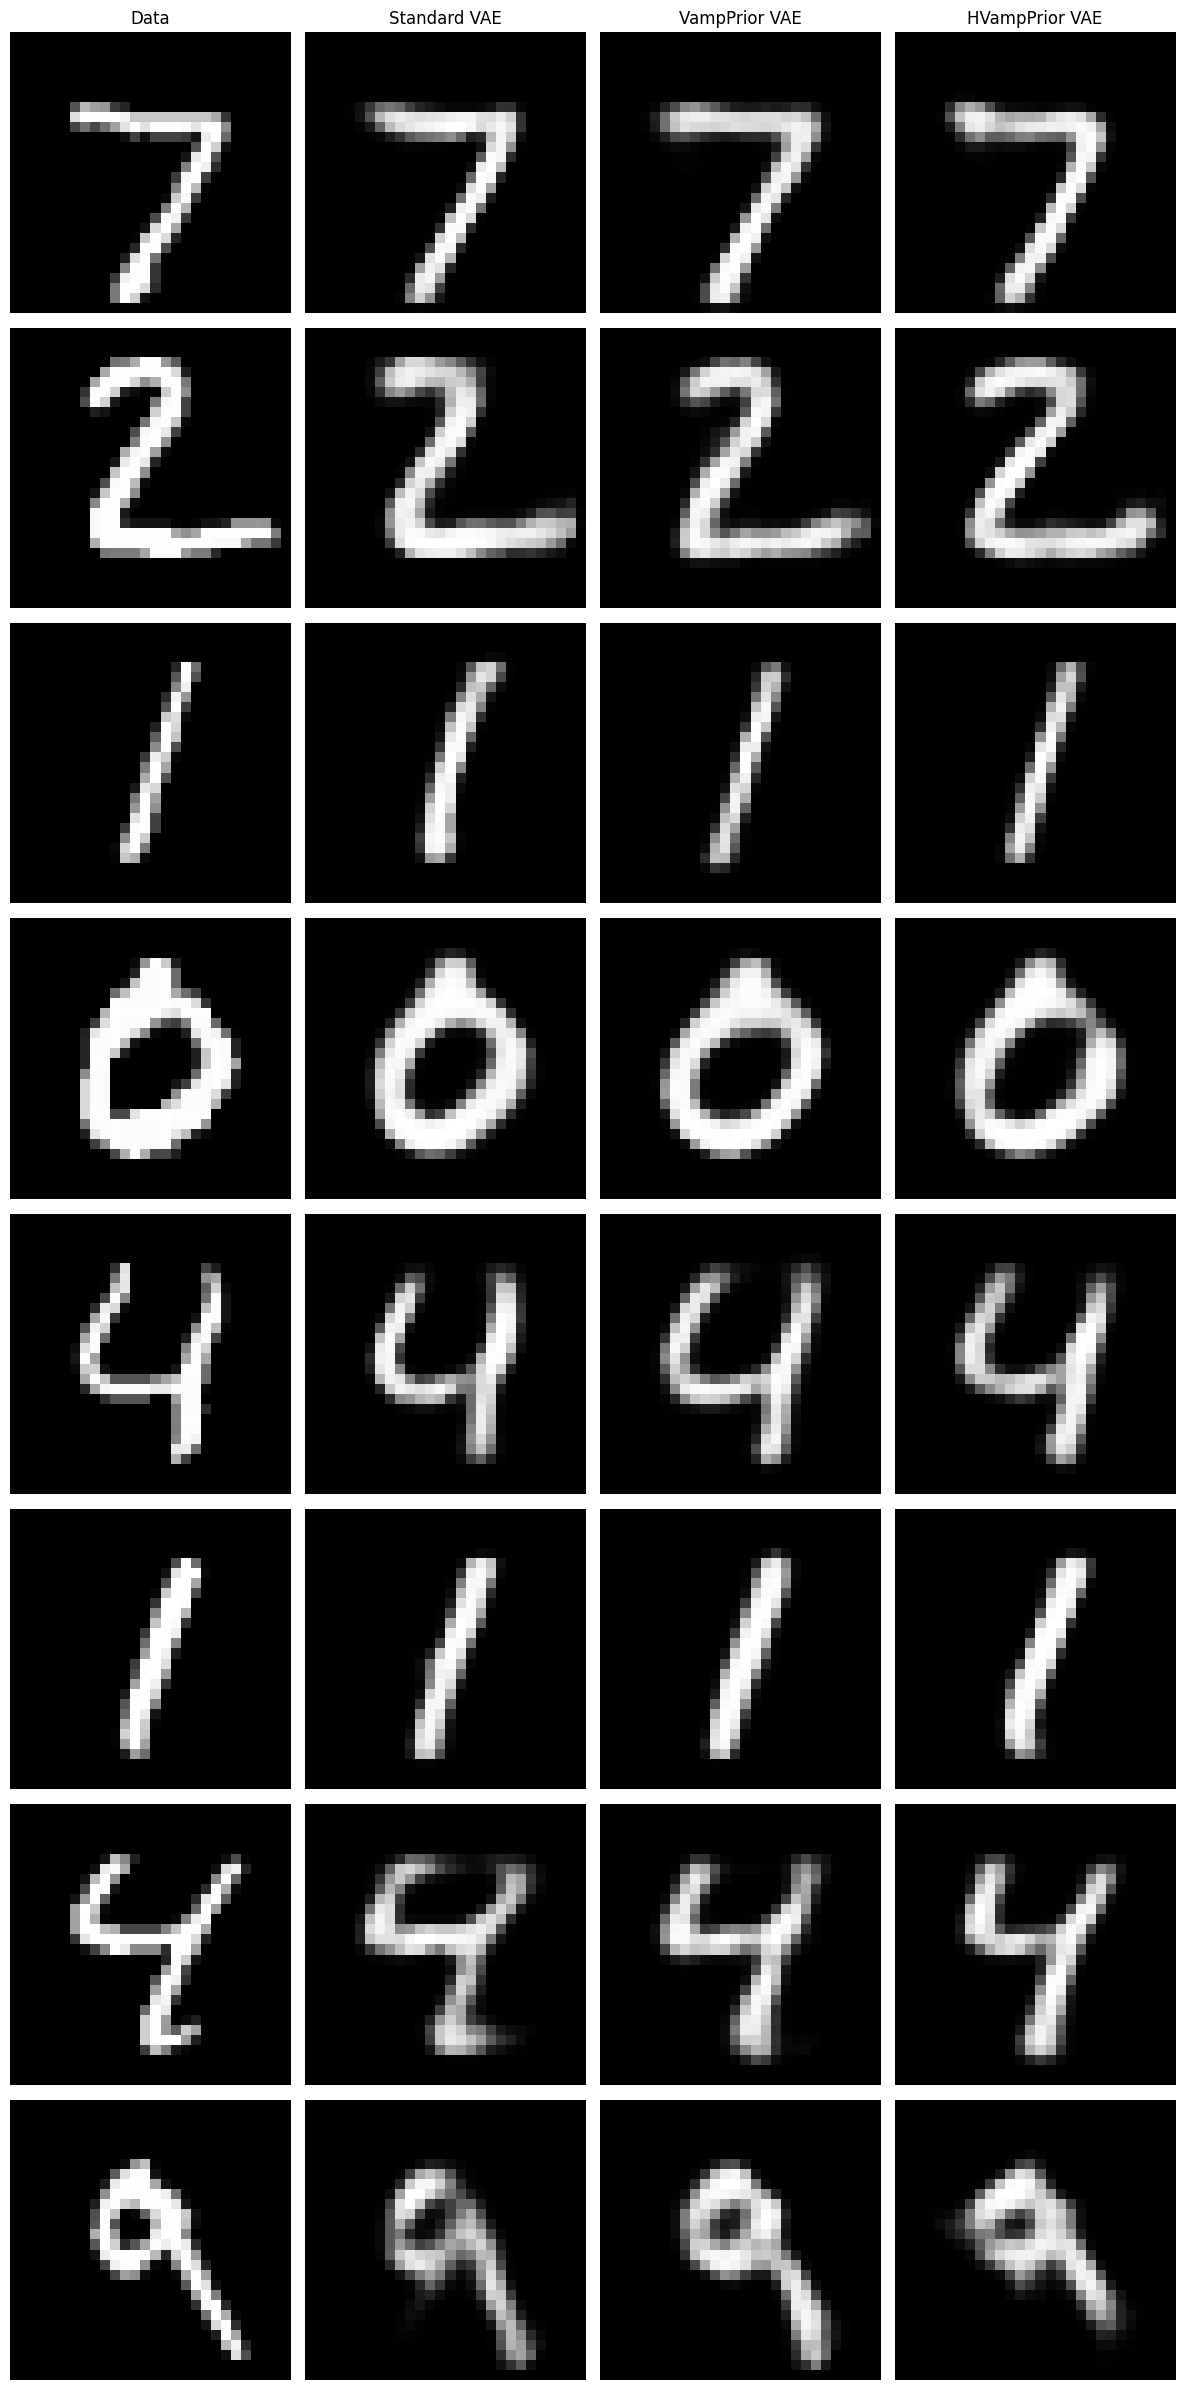

In [70]:
import matplotlib.pyplot as plt

# Set models to eval
HVamp_model.eval()
vamp_model.eval()
standard_model.eval()

# grab one batch from test_loader
x, _ = next(iter(test_loader))
x = x.to(device)

with torch.no_grad():
    # HVampPrior
    x_logits_hv, *_ = HVamp_model(x)
    x_recon_hv = torch.sigmoid(x_logits_hv).cpu()

    # VampPrior
    x_logits_vamp, *_ = vamp_model(x)
    x_recon_vamp = torch.sigmoid(x_logits_vamp).cpu()

    # Standard VAE
    x_logits_std, *_ = standard_model(x)
    x_recon_std = torch.sigmoid(x_logits_std).cpu()

# move input to CPU
x = x.cpu()

n = 8  # number of examples to display
fig, axes = plt.subplots(n, 4, figsize=(12, 3*n))  # n rows, 4 columns

for i in range(n):
    images = [x[i, 0], x_recon_std[i, 0], x_recon_vamp[i, 0], x_recon_hv[i, 0]]
    titles = ["Data", "Standard VAE", "VampPrior VAE", "HVampPrior VAE"]

    for j in range(4):
        axes[i, j].imshow(images[j], cmap="gray")
        axes[i, j].axis("off")
        if i == 0:
            axes[i, j].set_title(titles[j])

plt.tight_layout()
plt.show()
